## Домашнее задание №3. Классификатор текстового контента

In [1]:
import re
import nltk
import pymorphy2
from collections import Counter
import razdel
from tqdm import tqdm_notebook
from unidecode import unidecode


from googletrans import Translator, constants
import html
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing  import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from IPython.core.display import HTML, display



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set()

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_9412\1166365904.py:27: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


In [2]:
SEED = 42
np.random.seed(SEED)

TOKEN_PATTERN = "[а-яёa-z]+"

In [3]:
content_dataset = pd.read_csv('C:\\Users\\Пользователь\\Desktop\\Tehcnopark\\ML\\HomeWork_content_filter\\tools\\train.csv')
content_dataset.head()

,ID,url,title,label
0,0,m.kp.md,"Экс-министр экономики Молдовы - главе МИДЭИ, ц...",0
1,1,www.kp.by,Эта песня стала известна многим телезрителям б...,0
2,2,fanserials.tv,Банши 4 сезон 2 серия Бремя красоты смотреть о...,0
3,3,colorbox.spb.ru,Не Беси Меня Картинки,0
4,4,tula-sport.ru,В Новомосковске сыграют следж-хоккеисты алекси...,0


In [4]:
test_dataset = pd.read_csv('tools//test.csv')
test_dataset.head()

,ID,url,title
0,135309,www.kommersant.ru,Шестой кассационный суд в Самаре начнет работу...
1,135310,urexpert.online,"Что такое индексация алиментов, кем и в каких ..."
2,135311,imperimeha.ru,Женщинам | Империя Меха - Part 12
3,135312,national-porn.com,"Небритые, волосатые киски: Порно всех стран и ..."
4,135313,2gis.ru,67


In [4]:
content_dataset.describe()

,ID,label
count,135309.000000,135309.000000
mean,67654.000000,0.123532
std,39060.488124,0.329048
min,0.000000,0.000000
25%,33827.000000,0.000000
50%,67654.000000,0.000000
75%,101481.000000,0.000000
max,135308.000000,1.000000


In [5]:
content_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135309 entries, 0 to 135308
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   ID      135309 non-null  int64 
 1   url     135309 non-null  object
 2   title   135308 non-null  object
 3   label   135309 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 4.1+ MB


In [6]:
content_dataset.query('label == 1').count()

ID       16715
url      16715
title    16715
label    16715
dtype: int64

In [7]:
content_dataset['text_length'] = content_dataset.title.str.len()
content_dataset.head()

,ID,url,title,label,text_length
0,0,m.kp.md,"Экс-министр экономики Молдовы - главе МИДЭИ, ц...",0,140.0
1,1,www.kp.by,Эта песня стала известна многим телезрителям б...,0,74.0
2,2,fanserials.tv,Банши 4 сезон 2 серия Бремя красоты смотреть о...,0,52.0
3,3,colorbox.spb.ru,Не Беси Меня Картинки,0,21.0
4,4,tula-sport.ru,В Новомосковске сыграют следж-хоккеисты алекси...,0,83.0


In [9]:
content_dataset.describe()

,ID,label,text_length
count,135309.000000,135309.000000,135308.000000
mean,67654.000000,0.123532,69.519171
std,39060.488124,0.329048,36.065493
min,0.000000,0.000000,1.000000
25%,33827.000000,0.000000,45.000000
50%,67654.000000,0.000000,66.000000
75%,101481.000000,0.000000,84.000000
max,135308.000000,1.000000,473.000000


Text(0.5, 1.0, 'Distribution for negatives')

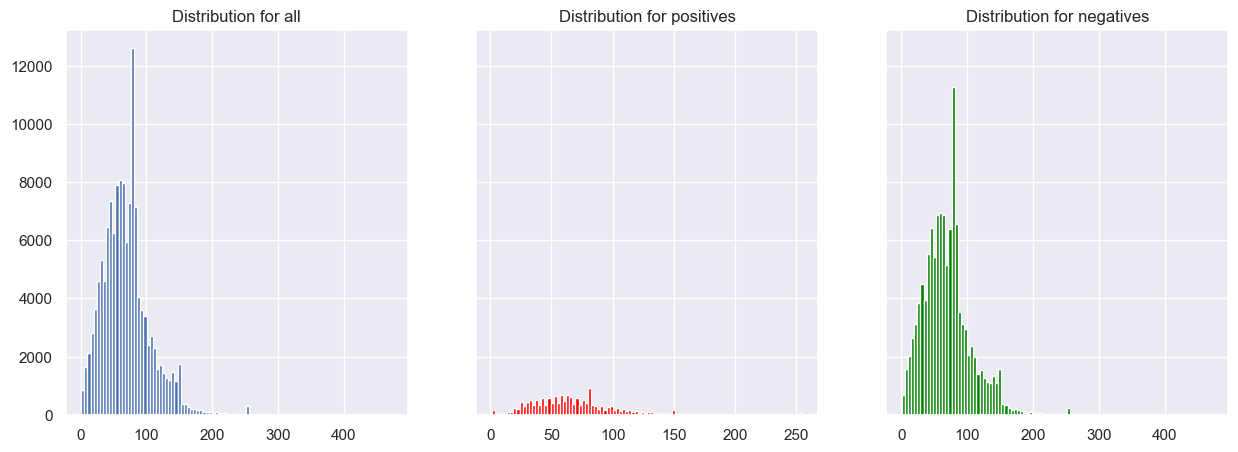

In [657]:
figure, axs = plt.subplots(1, 3, sharey=True, figsize = (15, 5))

lens_positive_class = content_dataset.query('label == 1').text_length.values
lens_negative_class = content_dataset.query('label == 0').text_length.values


axs[0].hist(content_dataset['text_length'], bins = 100)
axs[0].set_title('Distribution for all')

axs[1].hist(lens_positive_class, bins = 100, color = 'red')
axs[1].set_title('Distribution for positives')

axs[2].hist(lens_negative_class, bins = 100, color = 'green')
axs[2].set_title('Distribution for negatives')

In [8]:
content_dataset = content_dataset.query('text_length >= 3 & text_length <= 196')

### В целом, длины для негативных классов по распредлению выше, чем у позитивных. Есть и шумовые предметы в выборке. Посмотрим перцентили по длинам

In [11]:
print(content_dataset.query('label == 1')['text_length'].quantile(0.01))
print(content_dataset.query('label == 0')['text_length'].quantile(0.01))
print(content_dataset.query('label == 1')['text_length'].quantile(0.99))
print(content_dataset.query('label == 0')['text_length'].quantile(0.99))
print(len(content_dataset.query('label == 0 & text_length > 18 & text_length < 139')['text_length']))
print(len(content_dataset.query('label == 1 & text_length > 23 & text_length < 131')['text_length']))

15.0
8.0
150.0
160.0
106339
14976


### Но выборка сама по себе не сбалансирована, поэтому пока фильтровать по длине не будем, а поизвлекаем другие признаки и посмотрим на их распределения

In [12]:
print(content_dataset.query('label == 0').shape)
print(content_dataset.query('label == 1').shape)

(117679, 5)
(16399, 5)


### Посмотрим на распредедения по длинам url

Text(0.5, 1.0, 'Distribution for negatives')

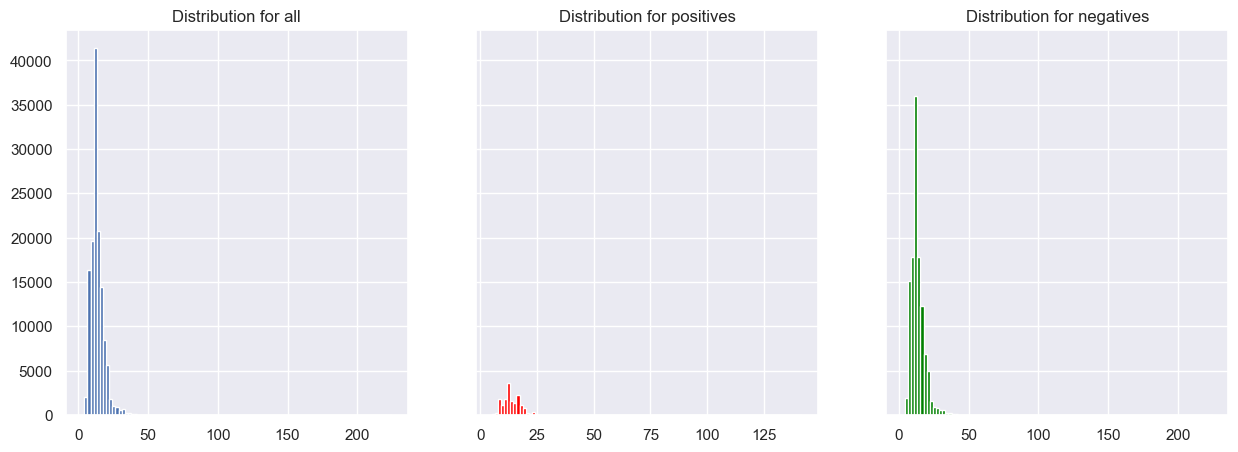

In [661]:
content_dataset['url_length'] = content_dataset.url.str.len()
figure, axs = plt.subplots(1, 3, sharey=True, figsize = (15, 5))

lens_positive_class = content_dataset.query('label == 1').url_length.values
lens_negative_class = content_dataset.query('label == 0').url_length.values


axs[0].hist(content_dataset['url_length'], bins = 100)
axs[0].set_title('Distribution for all')

axs[1].hist(lens_positive_class, bins = 100, color = 'red')
axs[1].set_title('Distribution for positives')

axs[2].hist(lens_negative_class, bins = 100, color = 'green')
axs[2].set_title('Distribution for negatives')


In [6]:
content_dataset.head()

,ID,url,title,label,text_length
0,0,m.kp.md,"Экс-министр экономики Молдовы - главе МИДЭИ, ц...",0,140.0
1,1,www.kp.by,Эта песня стала известна многим телезрителям б...,0,74.0
2,2,fanserials.tv,Банши 4 сезон 2 серия Бремя красоты смотреть о...,0,52.0
3,3,colorbox.spb.ru,Не Беси Меня Картинки,0,21.0
4,4,tula-sport.ru,В Новомосковске сыграют следж-хоккеисты алекси...,0,83.0


In [9]:
def string_processor(x):
    return x.split('.')

content_dataset['new_url'] = content_dataset[['url']].applymap(string_processor)
# content_dataset = content_dataset.drop(columns = 'url')

In [ ]:
test_dataset['new_url'] = test_dataset[['url']].applymap(string_processor)

### Делаем преобразрвание -> оставляем только информативную часть от url и домен сайта через функции. Зачастую у порносайтов домены нетривиальные, названия так же отличаются от обычных. Возможно, это внесет какой-то импакт

In [10]:
def get_domain(x):
    if len(x) == 1 :
        return 'com'
    else:
        return x[-1]
    
def get_pre_domain(x):
    if len(x) == 1:
        return x[0]
    else:
        start = -1
        while len(x[start]) < 4:
            if x[start] != x[0]:
                start = start - 1
            else:
                start = start + 1
                break
            
        return x[start]  
    
    
content_dataset['url_domain'] = content_dataset[['new_url']].applymap(get_domain)
content_dataset['site_name'] = content_dataset[['new_url']].applymap(get_pre_domain)

In [17]:
test_dataset['url_domain'] = test_dataset[['new_url']].applymap(get_domain)
test_dataset['site_name'] = test_dataset[['new_url']].applymap(get_pre_domain)

In [11]:
content_dataset = content_dataset.drop(columns = ['new_url'])

In [19]:
test_dataset = test_dataset.drop(columns = ['new_url'])

In [12]:
print(content_dataset['url_domain'].nunique())
print(content_dataset['site_name'].nunique())

296
30107


In [13]:
content_dataset.head()

,ID,url,title,label,text_length,url_domain,site_name
0,0,m.kp.md,"Экс-министр экономики Молдовы - главе МИДЭИ, ц...",0,140.0,md,kp
1,1,www.kp.by,Эта песня стала известна многим телезрителям б...,0,74.0,by,kp
2,2,fanserials.tv,Банши 4 сезон 2 серия Бремя красоты смотреть о...,0,52.0,tv,fanserials
3,3,colorbox.spb.ru,Не Беси Меня Картинки,0,21.0,ru,colorbox
4,4,tula-sport.ru,В Новомосковске сыграют следж-хоккеисты алекси...,0,83.0,ru,tula-sport


### Попробуем создать фичу на основе принадлежности домена к пересечению доменов классов или нет

In [14]:
domain_positives = content_dataset.query('label == 1')['url_domain'].unique()
domain_negatives = content_dataset.query('label == 0')['url_domain'].unique()
intersection = np.intersect1d(domain_negatives, domain_positives)

def domain_processor(x):
    if x not in intersection:
        if x in domain_negatives:
            return -1
        if x in domain_positives:
            return 1
    else:
        return 0

content_dataset['domain_unique_not'] = content_dataset[['url_domain']].applymap(domain_processor)

In [15]:
content_dataset['site_length'] = content_dataset.site_name.str.len()
content_dataset['url_length'] = content_dataset.url.str.len()

### Посмотрим на распределение информативных частей сайтов

Text(0.5, 1.0, 'Distribution for negatives')

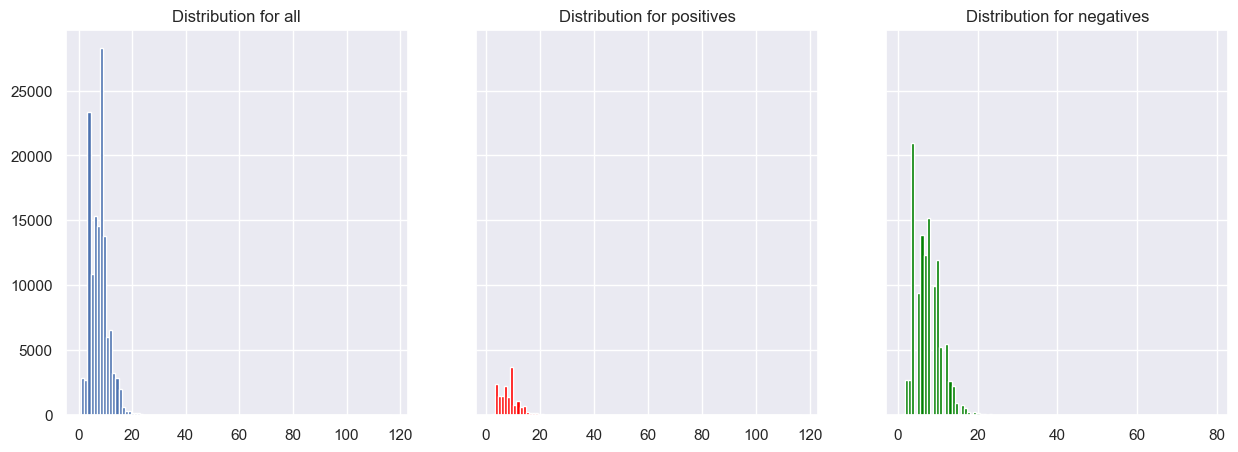

In [673]:
figure, axs = plt.subplots(1, 3, sharey=True, figsize = (15, 5))

lens_positive_class = content_dataset.query('label == 1').site_length.values
lens_negative_class = content_dataset.query('label == 0').site_length.values


axs[0].hist(content_dataset['site_length'], bins = 100)
axs[0].set_title('Distribution for all')

axs[1].hist(lens_positive_class, bins = 100, color = 'red')
axs[1].set_title('Distribution for positives')

axs[2].hist(lens_negative_class, bins = 100, color = 'green')
axs[2].set_title('Distribution for negatives')


### Как коррелируют между собой длины информативных частей и полные длины между собой

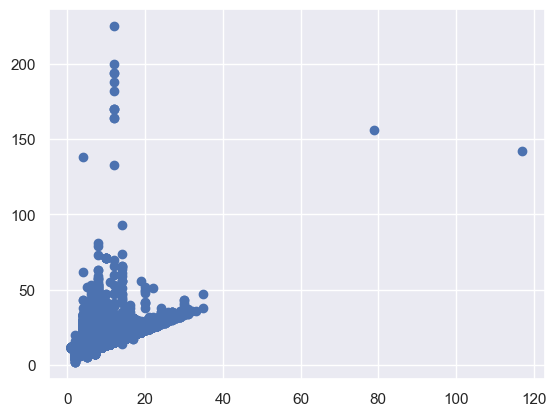

[[1.        0.5768507]
 [0.5768507 1.       ]]


In [674]:
plt.scatter(content_dataset['site_length'], content_dataset['url_length'], alpha = 1)
plt.show()
print(np.corrcoef(content_dataset['site_length'], content_dataset['url_length']))

### Матрица корреляции всего, что поизвлекали на текущий момент

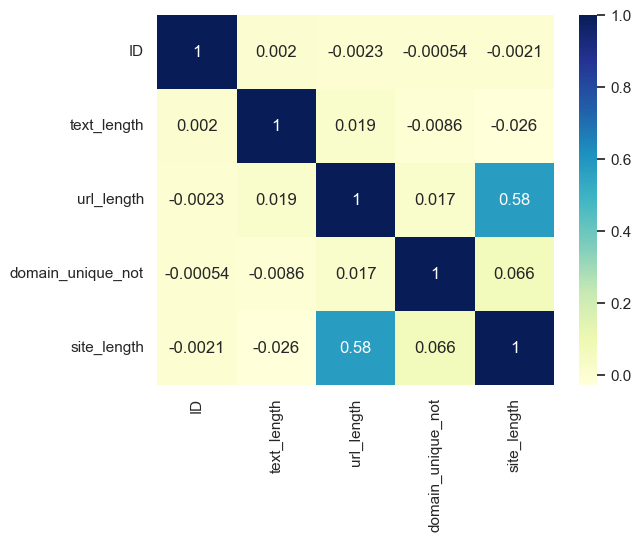

In [675]:
content_dataset_numerical = content_dataset.select_dtypes(include='number')
content_dataset_numerical_except_label = content_dataset_numerical.drop(columns = 'label')
dataplot = sns.heatmap(content_dataset_numerical_except_label.corr(), cmap="YlGnBu", annot=True) 

In [16]:
content_dataset.title = content_dataset.title.str.lower()

In [ ]:
test_dataset.title = test_dataset.title.str.lower()

In [26]:
test_dataset.head()

,ID,url,title,url_domain,site_name
0,135309,www.kommersant.ru,шестой кассационный суд в самаре начнет работу...,ru,kommersant
1,135310,urexpert.online,"что такое индексация алиментов, кем и в каких ...",online,online
2,135311,imperimeha.ru,женщинам | империя меха - part 12,ru,imperimeha
3,135312,national-porn.com,"небритые, волосатые киски: порно всех стран и ...",com,national-porn
4,135313,2gis.ru,67,ru,2gis


In [26]:
content_dataset['!_text'] = content_dataset.title.str.count('!')

(0.0, 36.0)

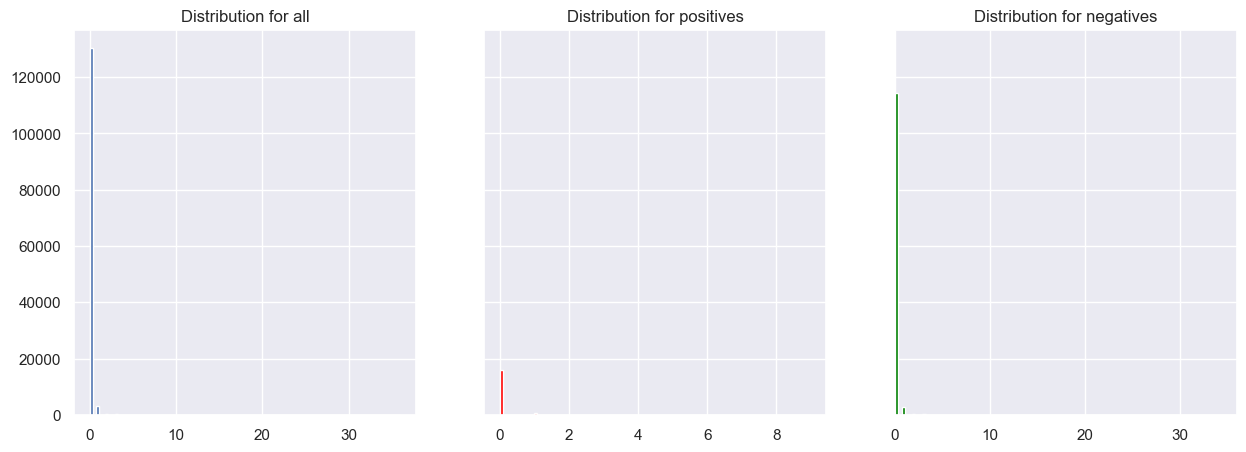

In [680]:
figure, axs = plt.subplots(1, 3, sharey=True, figsize = (15, 5))

lens_positive_class = content_dataset.query('label == 1')['!_text'].values
lens_negative_class = content_dataset.query('label == 0')['!_text'].values


axs[0].hist(content_dataset['!_text'], bins = 100)
axs[0].set_title('Distribution for all')

axs[1].hist(lens_positive_class, bins = 100, color = 'red')
axs[1].set_title('Distribution for positives')

axs[2].hist(lens_negative_class, bins = 100, color = 'green')
axs[2].set_title('Distribution for negatives')
plt.xlim([0, 36])


In [27]:
test_dataset.head()

,ID,url,title,url_domain,site_name
0,135309,www.kommersant.ru,шестой кассационный суд в самаре начнет работу...,ru,kommersant
1,135310,urexpert.online,"что такое индексация алиментов, кем и в каких ...",online,online
2,135311,imperimeha.ru,женщинам | империя меха - part 12,ru,imperimeha
3,135312,national-porn.com,"небритые, волосатые киски: порно всех стран и ...",com,national-porn
4,135313,2gis.ru,67,ru,2gis


In [17]:
corpus_texts = content_dataset.title.values
corpus_texts[:10]

array(['экс-министр экономики молдовы - главе мидэи, цель которого сделать из республики не просителя, а донора: надо избегать долгого нахождения н�',
       'эта песня стала известна многим телезрителям благодаря сериалу диверсант-2',
       'банши 4 сезон 2 серия бремя красоты смотреть онлайн!',
       'не беси меня картинки',
       'в новомосковске сыграют следж-хоккеисты алексинской «звезды» и сборной китая | т...',
       'салат: корейская морковь + копченая курица + кукуруза + сухарики, мой: калорийность, белки, жиры, углеводы',
       'угловой пневмогайковерт fubag rwc 105 1/2" 100320 в екатеринбурге - купить, цены, отзывы, характеристики, фото, инструкция',
       'табачный магазин `мир табака` | курительные трубки | stanwell | курительная труб',
       'league of legends » page 5 » porn comics free online',
       '08:00 (4766р), одесса - ростов-на-дону 20 сентября 2019, фаворит чп'],
      dtype=object)

In [18]:
def unidecoder(x):
    return unidecode(x)

In [13]:
content_dataset['title'] = content_dataset[['title']].applymap(unidecoder)

In [32]:
def translator(x):
    translated = GoogleTranslator(source='auto', target='en').translate(text=x)
    return translated

translator('Я люблю тебя')

'I love you'

In [ ]:
content_dataset['title'] = content_dataset[['title']].applymap(translator)

In [19]:
content_dataset.head(5)

,ID,url,title,label,text_length,url_domain,site_name,domain_unique_not,site_length,url_length
0,0,m.kp.md,"экс-министр экономики молдовы - главе мидэи, ц...",0,140.0,md,kp,-1,2,7
1,1,www.kp.by,эта песня стала известна многим телезрителям б...,0,74.0,by,kp,0,2,9
2,2,fanserials.tv,банши 4 сезон 2 серия бремя красоты смотреть о...,0,52.0,tv,fanserials,0,10,13
3,3,colorbox.spb.ru,не беси меня картинки,0,21.0,ru,colorbox,0,8,15
4,4,tula-sport.ru,в новомосковске сыграют следж-хоккеисты алекси...,0,83.0,ru,tula-sport,0,10,13


### Токенизация

In [20]:
def tokenize(text):
    return re.findall(TOKEN_PATTERN, text.lower())

documents = [tokenize(str(text)) for text in corpus_texts]

In [21]:
occurence = Counter([text for document in documents for text in document])
len(occurence)

162308

### Всего получили 164142 слов, которые необходимо отфильтровать и использовать в фичеризации
### Самые встречающиеся

In [ ]:
occurence.most_common(10) # Предлоги как и ожидалось заняли первое место

### Распределение слов по частоте

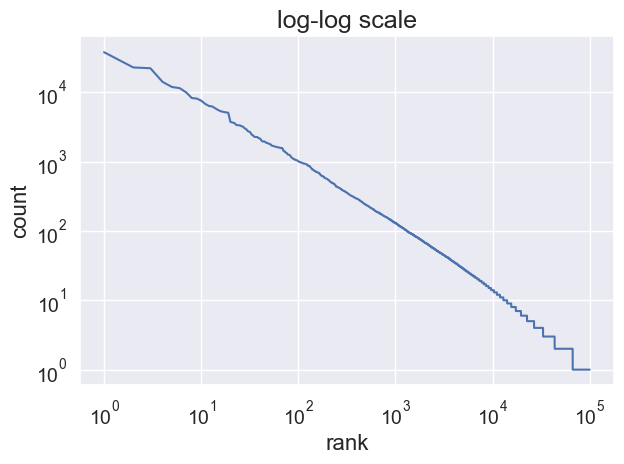

In [22]:
stopword_set = set(nltk.corpus.stopwords.words('russian'))
stopword_set_english = set(nltk.corpus.stopwords.words('english'))
stopword_set = stopword_set.union({'это', 'который', 'весь', 'наш', 'свой', 'ещё', 'её', 'ваш', 'также', 'итак'})
stopword_set = stopword_set.union(stopword_set_english)

max_rank = 100000

counts = [count for i, count in occurence.most_common()[:max_rank]]

plt.plot(range(1, len(counts) + 1), counts)
plt.title('log-log scale', fontsize=18)
plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('rank', fontsize=16)
plt.ylabel('count', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# stemmer_russian = nltk.stem.SnowballStemmer('russian')
# stemmer_english = nltk.stem.SnowballStemmer('english')
lemmatizer = pymorphy2.MorphAnalyzer()

lemmatizer_cache = {}

def lemmatize(token):
    if lemmatizer.word_is_known(token):
        if token not in lemmatizer_cache:
            lemmatizer_cache[token] = lemmatizer.parse(token)[0].normal_form
        return lemmatizer_cache[token]
    return token

lemmatized_docs = [[lemmatize(token) for token in text] for text in tqdm_notebook(documents)]

cleared_docs = [[token for token in text if token not in stopword_set] for text in lemmatized_docs]

### Итак, отфильтровали при помощи лемматизации. После данных преобразований словарь уменьшился почти что в два раза по сути без особых потерь информации! Неплохо

In [ ]:
for array in tqdm_notebook(cleared_docs):
    array = [translator(word) for word in array]

In [28]:
len({token for text in cleared_docs for token in text})

118053

### Обновим датасет

In [24]:
content_dataset['title'] = cleared_docs

In [25]:
content_dataset

,ID,url,title,label,text_length,url_domain,site_name,domain_unique_not,site_length,url_length
0,0,m.kp.md,"[экс, министр, экономика, молдова, глава, мидэ...",0,140.0,md,kp,-1,2,7
1,1,www.kp.by,"[песня, стать, известный, многий, телезритель,...",0,74.0,by,kp,0,2,9
2,2,fanserials.tv,"[банши, сезон, серия, бремя, красота, смотреть...",0,52.0,tv,fanserials,0,10,13
3,3,colorbox.spb.ru,"[бесить, картинка]",0,21.0,ru,colorbox,0,8,15
4,4,tula-sport.ru,"[новомосковск, сыграть, следж, хоккеист, алекс...",0,83.0,ru,tula-sport,0,10,13
...,...,...,...,...,...,...,...,...,...,...
135304,135304,mail.ru,"[пора, тюльпан, турецкий, сериал, русский, язы...",0,82.0,ru,mail,0,4,7
135305,135305,www.ntv.ru,"[остросюжетный, сериал, шеф, игра, повышение, ...",0,56.0,ru,ntv,0,3,10
135306,135306,topclassiccarsforsale.com,"[plymouth, special, deluxe, hot, rod, automati...",0,135.0,com,topclassiccarsforsale,0,21,25
135307,135307,wowcream.ru,"[купить, skin, сыворотка, питательный, power, ...",0,94.0,ru,wowcream,0,8,11


### Теперь поcчитаем для каждого объекта датасета количество частей речи

In [ ]:
def count_lexemes(x):
    dict_lexemes = {}
    for word in x:
        result =  lemmatizer.parse(word)
        lexeme = result[0].tag.POS
        if lexeme not in list(dict_lexemes.keys()):
            dict_lexemes[lexeme] = 1
        else:
            dict_lexemes[lexeme] += 1
        
    return dict_lexemes

content_dataset['lexemes'] = content_dataset[['title']].applymap(count_lexemes)

In [156]:
dicts = content_dataset.lexemes.values
indexes = content_dataset.lexemes.index

sub_dataset = pd.DataFrame()
for i in indexes:
    sub_dataset = sub_dataset._append(dicts[i], ignore_index = True)

In [185]:
sub_dataset.head(10)

,NOUN,INFN,ADJF,ADVB
0,12.0,2.0,1.0,0.0
1,4.0,1.0,2.0,0.0
2,5.0,1.0,0.0,1.0
3,1.0,1.0,0.0,0.0
4,6.0,1.0,1.0,0.0
5,9.0,0.0,2.0,0.0
6,8.0,1.0,0.0,0.0
7,5.0,0.0,3.0,0.0
8,0.0,0.0,0.0,0.0
9,7.0,0.0,0.0,0.0


### Мне стало интересно поработать с частями речи и я решил посмотреть рапределения по частям речи для title'ов

In [186]:
sub_dataset = sub_dataset.fillna(0)
indexes = sub_dataset.astype(bool).sum()
indexes

NOUN    117368
INFN     46827
ADJF     64593
ADVB     22899
dtype: int64

In [ ]:
indexes = pd.DataFrame(indexes).loc[:, 0] > 20000
drop_columns = indexes[indexes == False].index
sub_dataset = sub_dataset.drop(columns = drop_columns) 
sub_dataset = sub_dataset.drop(columns = [None])

sub_dataset.head()

In [161]:
content_dataset = pd.concat([content_dataset, sub_dataset], axis = 1)

In [164]:
content_dataset = content_dataset.drop(columns = ['lexemes'])

Text(0.5, 1.0, 'Distribution for negatives')

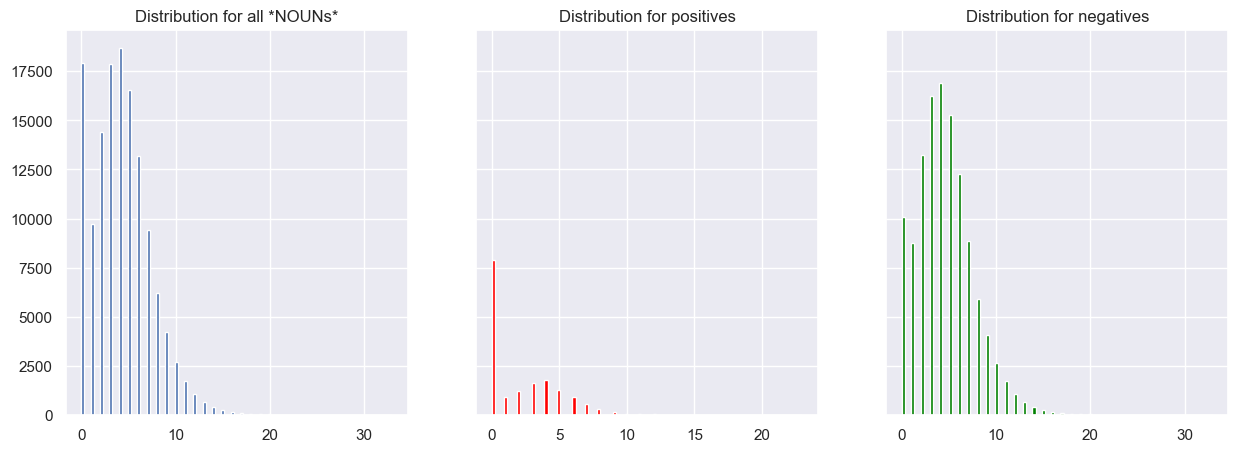

In [55]:
figure, axs = plt.subplots(1, 3, sharey=True, figsize = (15, 5))

lens_positive_class = content_dataset.query('label == 1').NOUN.values
lens_negative_class = content_dataset.query('label == 0').NOUN.values


axs[0].hist(content_dataset['NOUN'], bins = 100)
axs[0].set_title('Distribution for all *NOUNs*')

axs[1].hist(lens_positive_class, bins = 100, color = 'red')
axs[1].set_title('Distribution for positives')

axs[2].hist(lens_negative_class, bins = 100, color = 'green')
axs[2].set_title('Distribution for negatives')


Text(0.5, 1.0, 'Distribution for negatives')

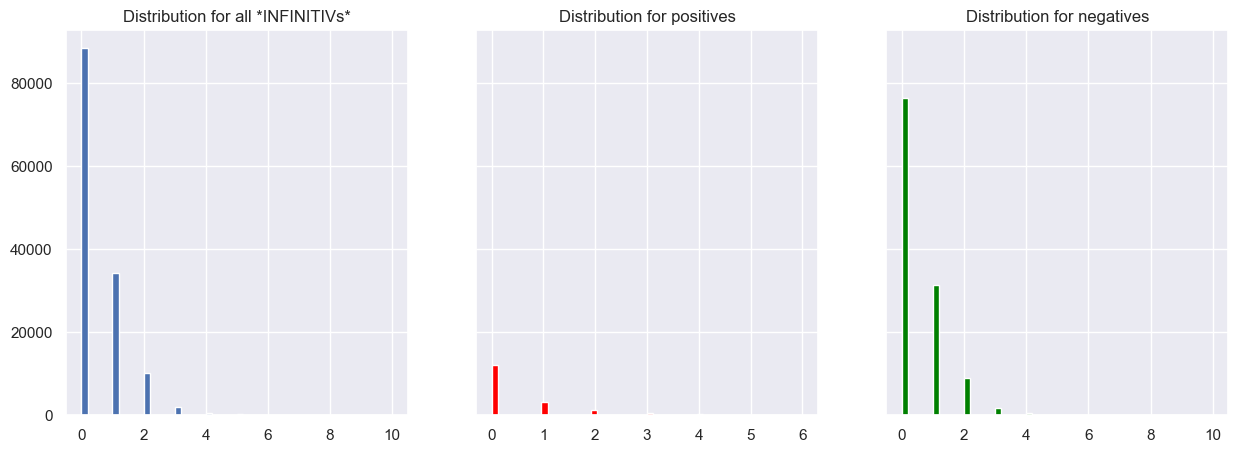

In [56]:
figure, axs = plt.subplots(1, 3, sharey=True, figsize = (15, 5))

lens_positive_class = content_dataset.query('label == 1').INFN.values
lens_negative_class = content_dataset.query('label == 0').INFN.values


axs[0].hist(content_dataset['INFN'], bins = 50)
axs[0].set_title('Distribution for all *INFINITIVs*')

axs[1].hist(lens_positive_class, bins = 50, color = 'red')
axs[1].set_title('Distribution for positives')

axs[2].hist(lens_negative_class, bins = 50, color = 'green')
axs[2].set_title('Distribution for negatives')


Text(0.5, 1.0, 'Distribution for negatives')

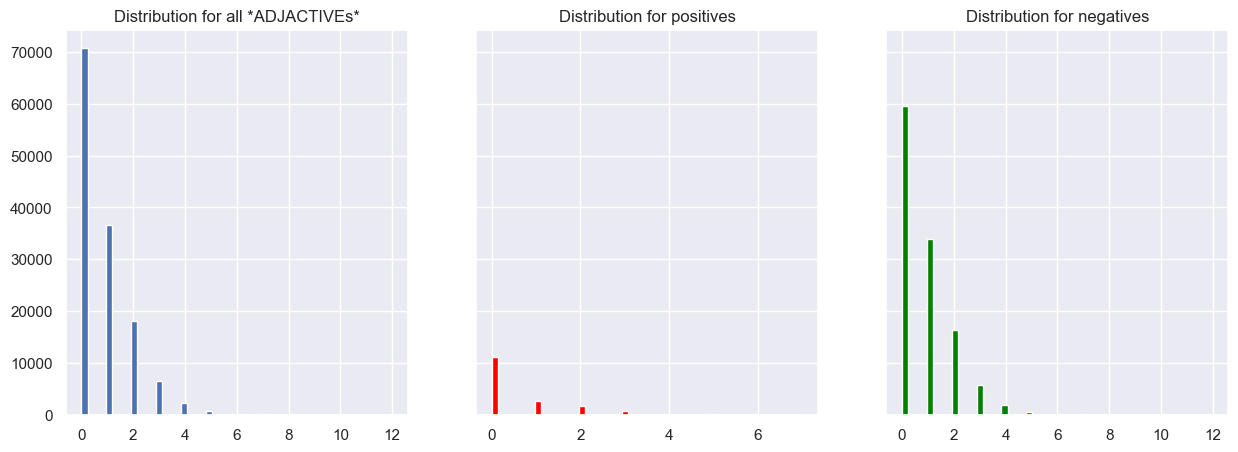

In [57]:
figure, axs = plt.subplots(1, 3, sharey=True, figsize = (15, 5))

lens_positive_class = content_dataset.query('label == 1').ADJF.values
lens_negative_class = content_dataset.query('label == 0').ADJF.values


axs[0].hist(content_dataset['ADJF'], bins = 50)
axs[0].set_title('Distribution for all *ADJACTIVEs*')

axs[1].hist(lens_positive_class, bins = 50, color = 'red')
axs[1].set_title('Distribution for positives')

axs[2].hist(lens_negative_class, bins = 50, color = 'green')
axs[2].set_title('Distribution for negatives')


In [165]:
content_dataset = content_dataset.drop(columns = ['ADVB'])

In [26]:
content_dataset.head()

,ID,url,title,label,text_length,url_domain,site_name,domain_unique_not,site_length,url_length
0,0,m.kp.md,"[экс, министр, экономика, молдова, глава, мидэ...",0,140.0,md,kp,-1,2,7
1,1,www.kp.by,"[песня, стать, известный, многий, телезритель,...",0,74.0,by,kp,0,2,9
2,2,fanserials.tv,"[банши, сезон, серия, бремя, красота, смотреть...",0,52.0,tv,fanserials,0,10,13
3,3,colorbox.spb.ru,"[бесить, картинка]",0,21.0,ru,colorbox,0,8,15
4,4,tula-sport.ru,"[новомосковск, сыграть, следж, хоккеист, алекс...",0,83.0,ru,tula-sport,0,10,13


### Идея в том, чтобы проредить в положительных и отрицательных экземплярах ложные слова. То есть если класс 0, то есть не порно, то убрать оттуда все двусвязные формы и наоборот. Конечно, моя реализация в каком-то смысле не очень, но можно заморорочиться с целым словарем подобных слов или придумать иную эвристику

In [167]:
false_words_negatives = ['спермия', 'сперматозоид', 'импотенция', 'импотент', 'рак', 'транссексуальный', 'транссексуал', 'пол', 'половой',
                         'гей-пара', 'гей', 'лгбт', 'групповой', 'насилие', 'изнасилование', 'изнасиловать']

false_words_positives = ['сюзана', 'анжела', 'снежана', 'отборный', 'видео', 'ублажать', 'горничный', 'вызов']

def delete_false_words_negatives(x):
    return [word for word in x if word not in false_words_negatives]

def delete_false_words_positives(x):
    return [word for word in x if word not in false_words_positives]


In [168]:
condition = content_dataset['label'] == 0
content_dataset.loc[condition, 'title'] = content_dataset[['title']].applymap(delete_false_words_negatives)
condition = content_dataset['label'] == 1
content_dataset.loc[condition, 'title'] = content_dataset[['title']].applymap(delete_false_words_positives)

In [27]:
def len_zero(x):
    return len(x) != 0

content_dataset['length_zero'] = content_dataset[['title']].applymap(len_zero)

In [28]:
content_dataset = content_dataset.loc[content_dataset['length_zero'] == True]

In [29]:
def drop_short_words(x):
    return [word for word in x if len(word) > 2]

content_dataset['title'] = content_dataset[['title']].applymap(drop_short_words)

In [30]:
content_dataset = content_dataset.drop(columns = ['length_zero'])

In [31]:
def text_regenerator(x):
    return ' '.join(x)

content_dataset['title'] = content_dataset[['title']].applymap(text_regenerator)

In [32]:
content_dataset.head()

,ID,url,title,label,text_length,url_domain,site_name,domain_unique_not,site_length,url_length
0,0,m.kp.md,экс министр экономика молдова глава мидэи цель...,0,140.0,md,kp,-1,2,7
1,1,www.kp.by,песня стать известный многий телезритель благо...,0,74.0,by,kp,0,2,9
2,2,fanserials.tv,банши сезон серия бремя красота смотреть онлайн,0,52.0,tv,fanserials,0,10,13
3,3,colorbox.spb.ru,бесить картинка,0,21.0,ru,colorbox,0,8,15
4,4,tula-sport.ru,новомосковск сыграть следж хоккеист алексински...,0,83.0,ru,tula-sport,0,10,13


In [ ]:
content_dataset.to_excel('dataset_spot.xlsx')

### Датасет очень большой и несбалансированный. Идея в том, чтобы создать выборку из нешумовых сэмплов из классов 1 и 0. Это будет сделано с помощью фильтрации шумовых объектов. Затем полагается сделать шаффл данных и после идти векторизовать текста по TF-IDF методике.  Далее можно обучить логистичсекую регрессию или применить другой алгоритм

In [33]:
def num_words_in_text(x):
    array_words = x.split()
    return len(array_words)

content_dataset = content_dataset.query('title != 0')

content_dataset['num_words'] = content_dataset[['title']].applymap(num_words_in_text)

### Посмотрим на распределние по количествам слов

Text(0.5, 1.0, 'Distribution for negatives')

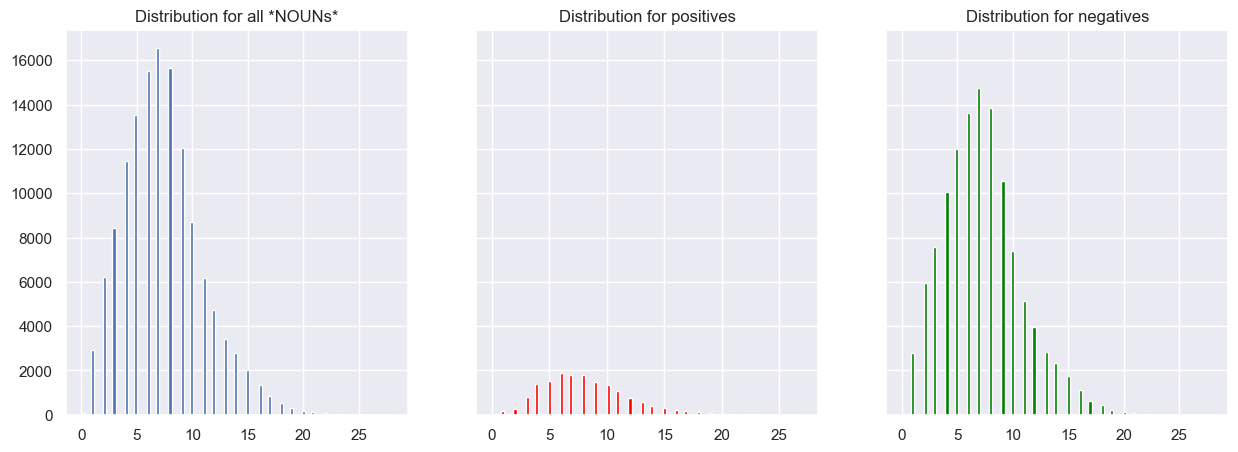

In [105]:
figure, axs = plt.subplots(1, 3, sharey=True, figsize = (15, 5))

lens_positive_class = content_dataset.query('label == 1').num_words.values
lens_negative_class = content_dataset.query('label == 0').num_words.values


axs[0].hist(content_dataset['num_words'], bins = 100)
axs[0].set_title('Distribution for all *NOUNs*')

axs[1].hist(lens_positive_class, bins = 100, color = 'red')
axs[1].set_title('Distribution for positives')

axs[2].hist(lens_negative_class, bins = 100, color = 'green')
axs[2].set_title('Distribution for negatives')


In [47]:
print(content_dataset.query('label == 1')['num_words'].quantile(0.05))
print(content_dataset.query('label == 0')['num_words'].quantile(0.05))
print(content_dataset.query('label == 1')['num_words'].quantile(0.99))
print(content_dataset.query('label == 0')['num_words'].quantile(0.99))
# print(len(content_dataset.query('label == 0 & text_length > 18 & text_length < 139')['text_length']))
# print(len(content_dataset.query('label == 1 & text_length > 23 & text_length < 131')['text_length']))

3.0
2.0
19.0
17.0


### Попробуем отсечь все нулевые меньше 2 и больше 20

In [34]:
content_dataset = content_dataset.query('num_words > 2 & num_words <= 20')

In [35]:
content_dataset.head()

,ID,url,title,label,text_length,url_domain,site_name,domain_unique_not,site_length,url_length,num_words
0,0,m.kp.md,экс министр экономика молдова глава мидэи цель...,0,140.0,md,kp,-1,2,7,14
1,1,www.kp.by,песня стать известный многий телезритель благо...,0,74.0,by,kp,0,2,9,8
2,2,fanserials.tv,банши сезон серия бремя красота смотреть онлайн,0,52.0,tv,fanserials,0,10,13,7
4,4,tula-sport.ru,новомосковск сыграть следж хоккеист алексински...,0,83.0,ru,tula-sport,0,10,13,8
5,5,beregifiguru.ru,салат корейский морковь копчёный курица кукуру...,0,106.0,ru,beregifiguru,0,12,15,11


### Попробуем отфильтровать по количеству сущесвтительных

In [51]:
a = content_dataset

In [205]:
content_dataset.to_excel('dataset_spot.xlsx')

In [148]:
content_dataset = pd.read_excel('dataset_spot.xlsx')

In [36]:
len(content_dataset)

124195

In [37]:
Y_target = content_dataset.select_dtypes(include=np.number)['label']
X_features = content_dataset.select_dtypes(include=np.number).drop(columns = ['ID', 'label'])

In [34]:

X_features

,text_length,site_length,url_length,num_words
0,140.0,2,7,14
1,74.0,2,9,8
2,52.0,10,13,7
4,83.0,10,13,8
5,106.0,12,15,11
...,...,...,...,...
135304,82.0,4,7,9
135305,56.0,3,10,6
135306,135.0,21,25,15
135307,94.0,8,11,9


In [38]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_features, Y_target)

GaussianNB()

In [39]:
content_dataset.shape

(124195, 11)

In [40]:
content_dataset['probas'] = naive_bayes.predict_proba(X_features).max(axis = 1)

### Появилось желание посмотреть распределение вероятностей по Байесу

In [41]:
print(content_dataset.query('label == 1')['probas'].quantile(0.01))
print(content_dataset.query('label == 0')['probas'].quantile(0.01))
print(content_dataset.query('label == 1')['probas'].quantile(0.99))
print(content_dataset.query('label == 0')['probas'].quantile(0.99))

0.7573557285993477
0.7855219985105371
0.9999974264950129
0.9997491984648381


In [42]:
content_dataset = content_dataset.query('probas >= 0.51 & probas <= 0.99')

Text(0.5, 1.0, 'Distribution for negatives')

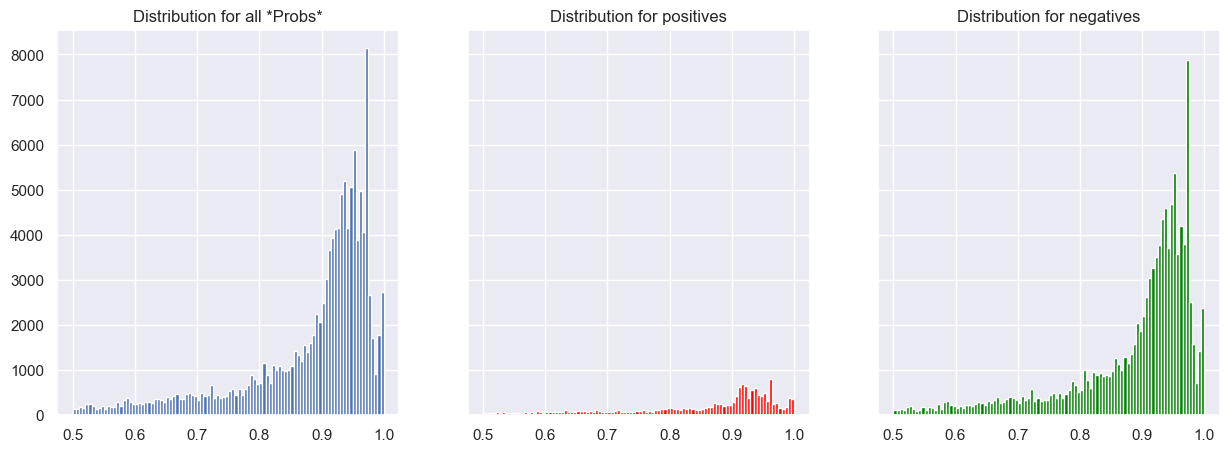

In [212]:
figure, axs = plt.subplots(1, 3, sharey=True, figsize = (15, 5))

lens_positive_class = content_dataset.query('label == 1').probas.values
lens_negative_class = content_dataset.query('label == 0').probas.values


axs[0].hist(content_dataset['probas'], bins = 100)
axs[0].set_title('Distribution for all *Probs*')

axs[1].hist(lens_positive_class, bins = 100, color = 'red')
axs[1].set_title('Distribution for positives')

axs[2].hist(lens_negative_class, bins = 100, color = 'green')
axs[2].set_title('Distribution for negatives')


Text(0.5, 1.0, 'Distribution for negatives')

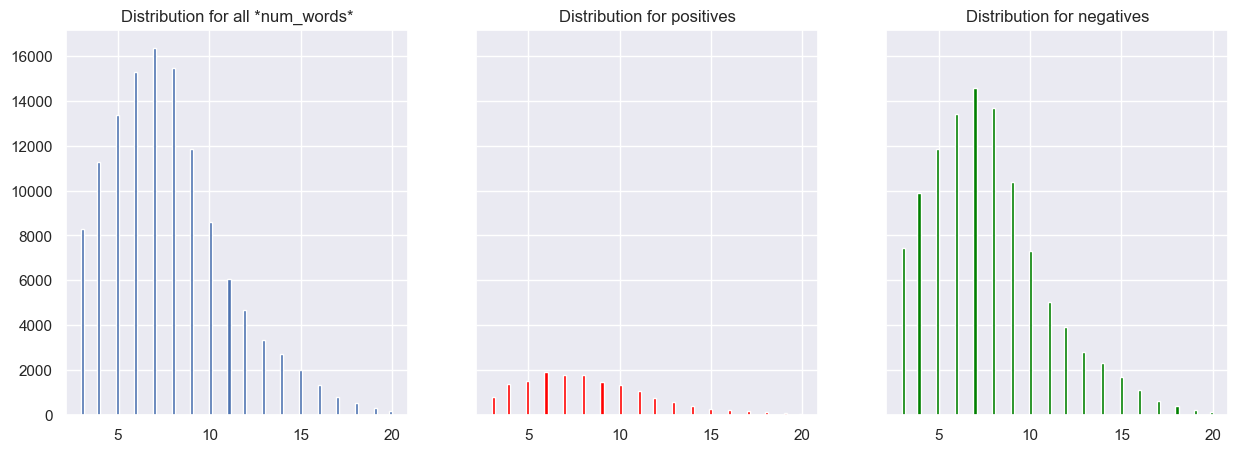

In [131]:
figure, axs = plt.subplots(1, 3, sharey=True, figsize = (15, 5))

lens_positive_class = content_dataset.query('label == 1').num_words.values
lens_negative_class = content_dataset.query('label == 0').num_words.values


axs[0].hist(content_dataset['num_words'], bins = 100)
axs[0].set_title('Distribution for all *num_words*')

axs[1].hist(lens_positive_class, bins = 100, color = 'red')
axs[1].set_title('Distribution for positives')

axs[2].hist(lens_negative_class, bins = 100, color = 'green')
axs[2].set_title('Distribution for negatives')


In [43]:
content_dataset.num_words.max()

20

In [44]:
lemmatizer = pymorphy2.MorphAnalyzer()

common = ['video', 'download', 'видео', 'скачать', 'free', 'бесплатно', 'link', 'ссылка', 'смотреть', 'watch', 'online', 'онлайн', 
          'искать', 'search', 'страница', 'page', 'фото', 'image', 'photo', 'рак', 'film', 'movie', 'фильм', 'девушка', 'женщина', 'жена', 'мужчина']
def words_remover(x):
    return " ".join([word for word in x.split() if word not in common][:15])

def lemmatize(token):
    if lemmatizer.word_is_known(token):
        if token not in lemmatizer_cache:
            lemmatizer_cache[token] = lemmatizer.parse(token)[0].normal_form
        return lemmatizer_cache[token]
    return token

In [45]:
content_dataset['title'] = content_dataset[['title']].applymap(words_remover)

In [ ]:
def apply_translator(x):
    return " ".join([translator(word) for word in x.split()])

content_dataset['title']  = content_dataset[['title']].applymap(apply_translator)

In [46]:
content_dataset.head()

,ID,url,title,label,text_length,url_domain,site_name,domain_unique_not,site_length,url_length,num_words,probas
1,1,www.kp.by,песня стать известный многий телезритель благо...,0,74.0,by,kp,0,2,9,8,0.940733
2,2,fanserials.tv,банши сезон серия бремя красота,0,52.0,tv,fanserials,0,10,13,7,0.872143
4,4,tula-sport.ru,новомосковск сыграть следж хоккеист алексински...,0,83.0,ru,tula-sport,0,10,13,8,0.885844
5,5,beregifiguru.ru,салат корейский морковь копчёный курица кукуру...,0,106.0,ru,beregifiguru,0,12,15,11,0.851875
6,6,ekb.vseinstrumenti.ru,угловой пневмогайковерт fubag rwc екатеринбург...,0,122.0,ru,vseinstrumenti,0,14,21,11,0.898739


In [ ]:
test_dataset['title'] = test_dataset[['title']].applymap(words_remover)

In [ ]:
test_dataset.head()

In [47]:
content_dataset['title'] = content_dataset[['title']].applymap(words_remover)

In [48]:
content_dataset.query('label == 1')

,ID,url,title,label,text_length,url_domain,site_name,domain_unique_not,site_length,url_length,num_words,probas
8,8,xlecx.com,league legends porn comics,1,52.0,com,xlecx,0,5,9,7,0.934054
12,12,pornmult.info,кримпай мать сын порно мультик порно комикс хе...,1,98.0,info,info,0,4,13,12,0.902352
19,19,24eropixel.net,мужик поставить блондинка отодрать тугой очко ...,1,86.0,net,24eropixel,0,10,14,11,0.859020
21,21,gdespaces.com,порно spaces spcs,1,52.0,com,gdespaces,0,9,13,5,0.887335
41,41,hdxclub.com,лесбийский секс кунилингусом стройный студентк...,1,110.0,com,hdxclub,0,7,11,11,0.921170
...,...,...,...,...,...,...,...,...,...,...,...,...
135221,135221,nola-london.com,pinoy biggest collection pinoy quality clips n...,1,65.0,com,nola-london,0,11,15,8,0.856929
135239,135239,pornotwix.com,two titted blondes enjoy big cock negra,1,39.0,com,pornotwix,0,9,13,7,0.879364
135253,135253,sexlib.org,всё рассказ первый знакомство секс эротический...,1,78.0,org,sexlib,0,6,10,8,0.928766
135256,135256,pakistanporn.info,food wild indian tube pakistanporn info,1,42.0,info,info,0,4,17,6,0.914557


### Можно также посмотреть на парметра числа ссылок внутри текстов. При 18+ текстах очень много ссылок на ресурсы

In [123]:
links = '(https?://\S+|www\.\S+)'
def number_links(x):
    return len(re.findall(links, x))

content_dataset['number_links'] = content_dataset[['title']].applymap(number_links)

In [49]:
content_dataset.shape

(119834, 12)

### Таких экземпляров ноль, выходит -> фича мусорная

Text(0.5, 1.0, 'Distribution for negatives')

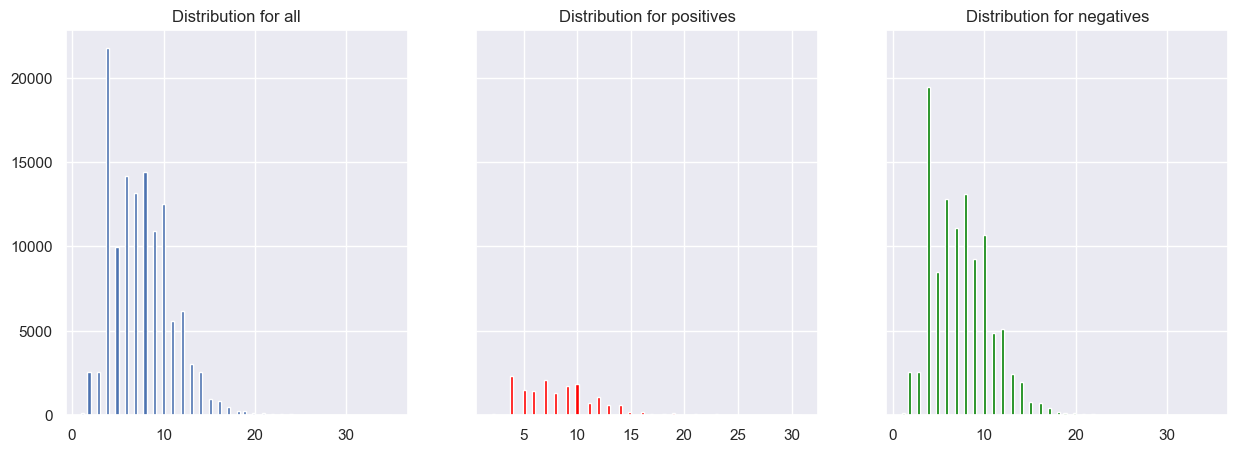

In [136]:
figure, axs = plt.subplots(1, 3, sharey=True, figsize = (15, 5))

lens_positive_class = content_dataset.query('label == 1').site_length.values
lens_negative_class = content_dataset.query('label == 0').site_length.values


axs[0].hist(content_dataset['site_length'], bins = 100)
axs[0].set_title('Distribution for all')

axs[1].hist(lens_positive_class, bins = 100, color = 'red')
axs[1].set_title('Distribution for positives')

axs[2].hist(lens_negative_class, bins = 100, color = 'green')
axs[2].set_title('Distribution for negatives')


In [254]:
print(content_dataset.query('label == 1')['site_length'].quantile(0.01))
print(content_dataset.query('label == 0')['site_length'].quantile(0.01))
print(content_dataset.query('label == 1')['site_length'].quantile(0.99))
print(content_dataset.query('label == 0')['site_length'].quantile(0.99))

4.0
2.0
19.0
17.0


In [50]:
content_dataset = content_dataset.query('site_length >=2 & site_length <= 18')

In [57]:
content_dataset['title']

1         [pesnia, stat', izvestnyi, mnogii, telezritel'...
2                  [banshi, sezon, seriia, bremia, krasota]
4         [novomoskovsk, sygrat', sledzh, khokkeist, ale...
5         [salat, koreiskii, morkov', kopchionyi, kurits...
6         [uglovoi, pnevmogaikovert, fubag, rwc, ekateri...
                                ...                        
135303                    [toyota, yaris, yaris, sell, buy]
135304    [pora, tiul'pan, turetskii, serial, russkii, i...
135305    [ostrosiuzhetnyi, serial, shef, igra, povyshen...
135307    [kupit', skin, syvorotka, pitatel'nyi, power, ...
135308    [tekhnicheskii, spirt, kanistra, flakon, kupit...
Name: title, Length: 119101, dtype: object

In [68]:
def text_regenerator(x):
    return ' '.join(x)
content_dataset['title'] = content_dataset[['title']].applymap(text_regenerator)

In [53]:
content_dataset['title'] = content_dataset[['title']].applymap(unidecoder)

In [60]:
from gensim.models import Word2Vec

def splitter(x):
    return x.split()

content_dataset['title'] = content_dataset[['title']].applymap(splitter)
sentences = content_dataset['title']

# Пример предобработки текста и подготовки данных

# Загрузка предобученной модели Word2Vec или создание и обучение собственной модели
w2v_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4, sg=0)  # Пример создания и обучения модели

In [61]:
w2v_model.wv.most_similar(positive='seks')

[('khudenkii', 0.978549063205719),
 ('minut', 0.9756140112876892),
 ('trakhnut', 0.9747576117515564),
 ('molodoi', 0.9739779233932495),
 ('zrelyi', 0.9732882380485535),
 ('sosat', 0.9713557362556458),
 ('pisia', 0.9692949652671814),
 ('trakhatsia', 0.9690665602684021),
 ('lesbi', 0.9689028263092041),
 ('razvesti', 0.9673916101455688)]

In [59]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# Обучение Word2Vec модели

# Преобразование текста в векторы Word2Vec
def text_to_vector(text):
    vector = []
    for word in text:
        if word in w2v_model.wv:
            vector.append(w2v_model.wv[word])
    return vector
X_vectors = [text_to_vector(text) for text in sentences]

In [59]:
def drop_tire(x):
    return x.replace('-', '')
def drop_apostrophe(x):
    return x.replace("'", '')

content_dataset['title'] = content_dataset[['title']].applymap(drop_tire)
content_dataset['title'] = content_dataset[['title']].applymap(drop_apostrophe)

In [163]:
X_train, X_test, Y_train, Y_test = train_test_split(content_dataset['title'].astype(str), content_dataset['label'], test_size = 0.2, random_state = 42)
w2v = Word2Vec([sentence.lower().split() for sentence in X_train.values], vector_size = 300, window = 5)

max_len = 15
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 25000)
tokenizer.fit_on_texts(X_train)

In [106]:
sentences = content_dataset[['title']].applymap(text_regenerator)['title']

In [167]:
X_train_sequences = tokenizer.texts_to_sequences(X_train.astype(str))
X_test_sequences = tokenizer.texts_to_sequences(X_test.astype(str))

In [168]:
X_train = tf.keras.utils.pad_sequences(X_train_sequences, maxlen = 15, padding = 'post', truncating = 'post')
X_test = tf.keras.utils.pad_sequences(X_test_sequences, maxlen = 15, padding = 'post', truncating = 'post')

In [169]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    try:
        embedding_matrix[i] = w2v.wv[i]
    except:
        embedding_matrix[i] = np.zeros(300)

In [171]:
embedding_matrix.shape

(91534, 300)

In [183]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(91534, 300, input_length = 15, weights = [embedding_matrix], trainable = True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')])
model.compile(optimizer = 'adam', metrics = ['accuracy'], loss = 'binary_crossentropy')
model.fit(X_train, Y_train, epochs=10, batch_size=64, validation_split=0.2)

# Оценка производительности модели
loss, accuracy = model.evaluate(X_test, Y_test)
print("Test Accuracy:", accuracy)
y_pred = (model.predict(X_test) > 0.5).astype('int32')
f1 = f1_score(y_true = Y_test, y_pred = y_pred)
print(f1)
print(classification_report(y_true = Y_test, y_pred = y_pred))

Epoch 1/10
1191/1191 [==============================] - 655s 538ms/step - loss: 0.0624 - accuracy: 0.9809 - val_loss: 0.0375 - val_accuracy: 0.9886
Epoch 2/10
1191/1191 [==============================] - 636s 534ms/step - loss: 0.0181 - accuracy: 0.9946 - val_loss: 0.0311 - val_accuracy: 0.9908
Epoch 3/10
1191/1191 [==============================] - 591s 496ms/step - loss: 0.0096 - accuracy: 0.9974 - val_loss: 0.0440 - val_accuracy: 0.9894
Epoch 4/10
1191/1191 [==============================] - 630s 529ms/step - loss: 0.0072 - accuracy: 0.9980 - val_loss: 0.0657 - val_accuracy: 0.9893
Epoch 5/10
1191/1191 [==============================] - 645s 541ms/step - loss: 0.0055 - accuracy: 0.9985 - val_loss: 0.0493 - val_accuracy: 0.9895
Epoch 6/10
1191/1191 [==============================] - 670s 562ms/step - loss: 0.0052 - accuracy: 0.9985 - val_loss: 0.0658 - val_accuracy: 0.9871
Epoch 7/10
1191/1191 [==============================] - 697s 586ms/step - loss: 0.0043 - accuracy: 0.9987 - val_

In [184]:
print(classification_report(y_true = Y_test, y_pred = y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     20892
           1       0.93      0.96      0.94      2929

    accuracy                           0.99     23821
   macro avg       0.96      0.97      0.97     23821
weighted avg       0.99      0.99      0.99     23821



In [ ]:
print(classification_report(y_true = Y_test, y_pred = y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     20892
           1       0.96      0.95      0.96      2929

    accuracy                           0.99     23821
   macro avg       0.98      0.97      0.98     23821
weighted avg       0.99      0.99      0.99     23821



In [ ]:
model.save('my_model.h5')

In [ ]:
model.save_weights('my_weights')

In [ ]:
w2v.wv.most_similar("seks")

[('sosat', 0.9627934694290161),
 ('trakhat', 0.9603622555732727),
 ('zrelyi', 0.9564337730407715),
 ('briunetka', 0.9532970190048218),
 ('trakhatsia', 0.9510602355003357),
 ('blondinka', 0.9481925368309021),
 ('dama', 0.9454161524772644),
 ('gei', 0.9442983865737915),
 ('seksualnyi', 0.9437835812568665),
 ('molodoi', 0.9437599182128906)]

In [ ]:
w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

In [ ]:
X_vectors_padded = tf.keras.preprocessing.sequence.pad_sequences(X_vectors, padding = 'post',
                                                                dtype = 'float32')

In [ ]:
y = content_dataset['label'] 

# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_vectors_padded, y, test_size=0.2, random_state=42)

In [ ]:
X_vectors_padded.reshape(X_vectors_padded.shape[0], -1).shape

(123346, 4500)

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# Обучение Word2Vec модели

# Преобразование текста в векторы Word2Vec
# def text_to_vector(text):
#     vector = []
#     for word in text:
#         if word in w2v_model.wv:
#             vector.append(w2v_model.wv[word])
#     return np.mean(vector, axis = 0) if vector else np.zeros(shape=(200,))

# X_vectors = [text_to_vector(text) for text in sentences]

# Преобразование входных данных в формат TensorFlow
# X_vectors_padded = tf.keras.preprocessing.sequence.pad_sequences(X_vectors, padding='post', dtype='float32')
# y = content_dataset['label'] 

# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_vectors_padded, y, test_size=0.2, random_state=42)

num_classes = 1

# Построение модели нейронной сети
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim = vocab_size, output_dim = 300, input_length = sequence_length,
                              mask_zero = True, trainable = False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

# Компиляция модели
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Обучение модели
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Оценка производительности модели
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)
y_pred = np.argmax(model.predict(X_test), axis = -1)
f1 = f1_score(y_true = y_test, y_pred = y_pred)
print(f1)
print(classification_report(y_true = y_test, y_pred = y_pred))

In [ ]:
np.argmax(model.predict(X_test), axis = -1)[np.argmax(model.predict(X_test), axis = -1) == 1]

771/771 [==============================] - 7s 8ms/step


array([], dtype=int64)

In [ ]:
print(classification_report(y_true = y_test, y_pred = y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93     21562
           1       0.00      0.00      0.00      3108

    accuracy                           0.87     24670
   macro avg       0.44      0.50      0.47     24670
weighted avg       0.76      0.87      0.82     24670



In [ ]:
result = model.predict(X_test) > 0.5

771/771 [==============================] - 9s 12ms/step


In [ ]:
y_pred = np.argmax(model.predict(X_test), axis = -1)

763/763 [==============================] - 8s 11ms/step


In [ ]:
sentences

0         [экс, министр, экономика, молдова, глава, мидэ...
1         [песня, стать, известный, многий, телезритель,...
2                     [банши, сезон, серия, бремя, красота]
4         [новомосковск, сыграть, следж, хоккеист, алекс...
5         [салат, корейский, морковь, копчёный, курица, ...
                                ...                        
135303                    [toyota, yaris, yaris, sell, buy]
135304    [пора, тюльпан, турецкий, сериал, русский, язы...
135305    [остросюжетный, сериал, шеф, игра, повышение, ...
135307    [купить, skin, сыворотка, питательный, power, ...
135308    [технический, спирт, канистра, флакон, купить,...
Name: title, Length: 122036, dtype: object

In [ ]:
X = np.array([np.mean([w2v_model.wv[word] for word in sentence if word in w2v_model.wv] or [np.zeros(150)], axis=0) for sentence in sentences])

In [ ]:
X.shape

(122036, 150)

In [ ]:
content_dataset['title']  = content_dataset[['title']].applymap(text_regenerator)

In [ ]:
content_dataset.query('label == 1')

In [ ]:
test_dataset.head()

In [ ]:
def drop_apostrophe(x):
    return x.replace("'", "")
content_dataset['title'] = content_dataset[['title']].applymap(drop_apostrophe)
def drop_dots(x):
    return x.replace('.', "")
content_dataset['url'] = content_dataset[['url']].applymap(drop_dots)
def drop_tire(x):
    return x.replace('-', "")
content_dataset['url'] = content_dataset[['url']].applymap(drop_tire)
content_dataset['title'] = content_dataset[['title']].applymap(drop_tire)
content_dataset['site_name'] = content_dataset[['site_name']].applymap(drop_tire)


In [ ]:
test_dataset['title'] = test_dataset[['title']].applymap(drop_apostrophe)
test_dataset['title'] = test_dataset[['title']].applymap(drop_tire)
test_dataset['url'] = test_dataset[['url']].applymap(drop_dots)
test_dataset['url'] = test_dataset[['url']].applymap(drop_tire)
test_dataset['site_name'] = test_dataset[['site_name']].applymap(drop_dots)

In [ ]:
test_dataset.head()

In [ ]:
content_dataset.shape

(122036, 11)

In [ ]:
positive_classes = content_dataset.query('label == 1')
negative_classes = content_dataset.query('label == 0')

In [ ]:
positive_classes_shuffle, positive_class_test = train_test_split(positive_classes, test_size = 0.2, random_state = SEED)

In [ ]:
positive_classes_shuffle.shape, positive_class_test.shape

((12426, 11), (3107, 11))

In [ ]:
negative_classes_shuffle, negative_class_test = train_test_split(negative_classes, test_size = 0.5, random_state = SEED)

In [ ]:
negative_classes_shuffle.shape, negative_class_test.shape

((53251, 11), (53252, 11))

In [ ]:
learning_content_dataset = pd.concat([positive_classes_shuffle, negative_classes_shuffle], axis = 0).sample(frac = 1)
test_content_dataset = pd.concat([positive_class_test, negative_class_test], axis = 0).sample(frac = 1)

In [ ]:
learning_content_dataset.shape

(65677, 11)

Text(0.5, 1.0, 'Distribution for negatives')

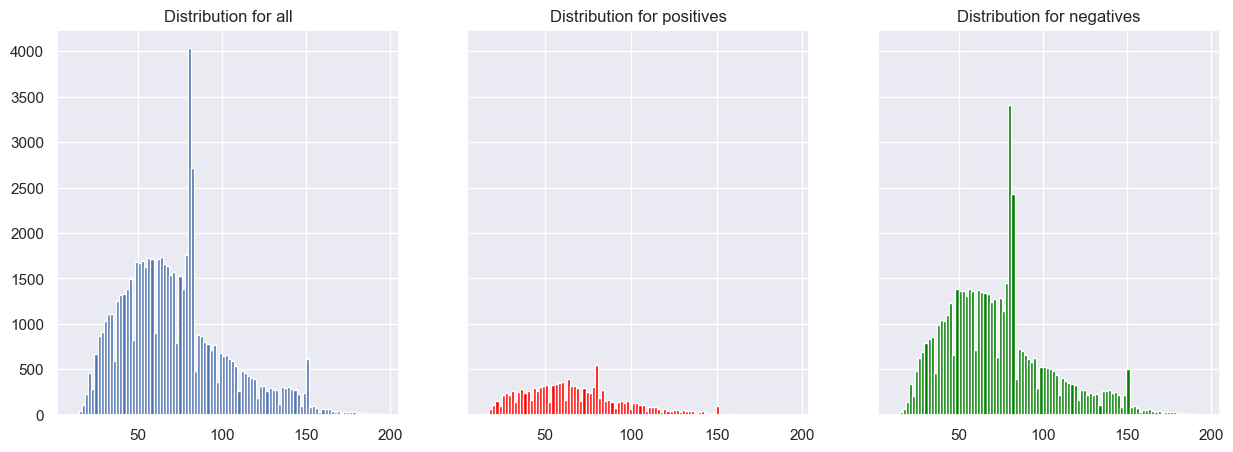

In [ ]:
figure, axs = plt.subplots(1, 3, sharey=True, figsize = (15, 5))

lens_positive_class = learning_content_dataset.query('label == 1').text_length.values
lens_negative_class = learning_content_dataset.query('label == 0').text_length.values


axs[0].hist(learning_content_dataset['text_length'], bins = 100)
axs[0].set_title('Distribution for all')

axs[1].hist(lens_positive_class, bins = 100, color = 'red')
axs[1].set_title('Distribution for positives')

axs[2].hist(lens_negative_class, bins = 100, color = 'green')
axs[2].set_title('Distribution for negatives')


In [ ]:
print(learning_content_dataset.query('label == 1')['text_length'].quantile(0.01))
print(learning_content_dataset.query('label == 0')['text_length'].quantile(0.01))
print(learning_content_dataset.query('label == 1')['text_length'].quantile(0.99))
print(learning_content_dataset.query('label == 0')['text_length'].quantile(0.99))

20.0
22.0
150.0
159.0


Text(0.5, 1.0, 'Distribution for negatives')

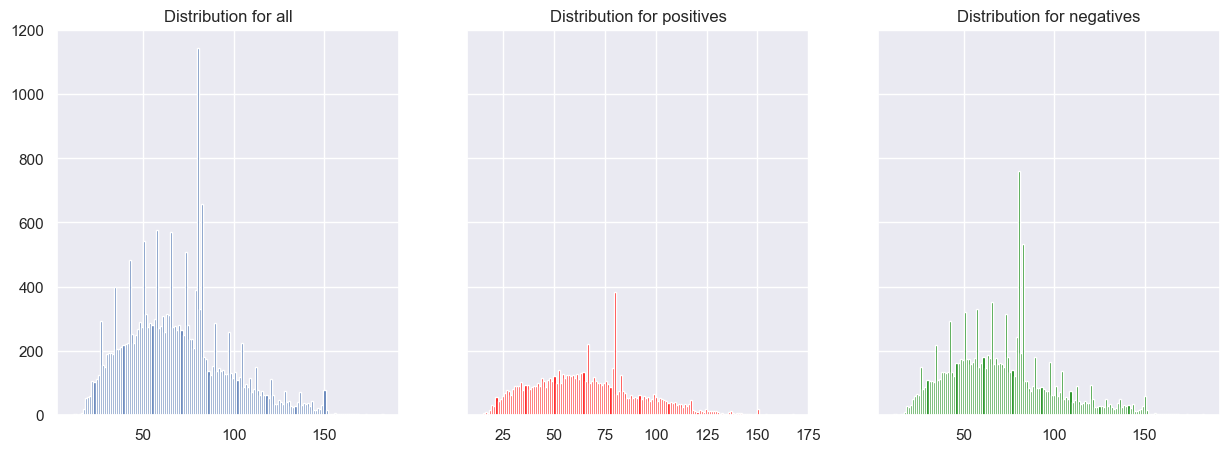

In [ ]:
figure, axs = plt.subplots(1, 3, sharey=True, figsize = (15, 5))

lens_positive_class = learning_content_dataset.query('label == 1').text_length.values
lens_negative_class = learning_content_dataset.query('label == 0').text_length.values


axs[0].hist(learning_content_dataset['text_length'], bins = 150)
axs[0].set_title('Distribution for all')

axs[1].hist(lens_positive_class, bins = 150, color = 'red')
axs[1].set_title('Distribution for positives')

axs[2].hist(lens_negative_class, bins = 150, color = 'green')
axs[2].set_title('Distribution for negatives')


In [ ]:
learning_content_dataset.dropna(inplace=True)

In [ ]:
learning_content_dataset.shape

(65677, 11)

In [ ]:
learning_content_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65501 entries, 83382 to 8860
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           65501 non-null  int64  
 1   url          65501 non-null  object 
 2   title        65501 non-null  object 
 3   label        65501 non-null  int64  
 4   text_length  65501 non-null  float64
 5   url_domain   65501 non-null  object 
 6   site_name    65501 non-null  object 
 7   site_length  65501 non-null  int64  
 8   url_length   65501 non-null  int64  
 9   num_words    65501 non-null  int64  
 10  probas       65501 non-null  float64
dtypes: float64(2), int64(5), object(4)
memory usage: 6.0+ MB


### SGDClassifier

In [ ]:
stopword_set = set(nltk.corpus.stopwords.words('russian'))
stopword_set_english = set(nltk.corpus.stopwords.words('english'))
stopword_set = stopword_set.union({'это', 'который', 'весь', 'наш', 'свой', 'ещё', 'её', 'ваш', 'также', 'итак'})
stopword_set = list(stopword_set.union(stopword_set_english))

count_model = Pipeline([
    (
        'vectorizer',
        CountVectorizer(
            lowercase=True, ngram_range=(1, 1), token_pattern=TOKEN_PATTERN,
            stop_words=stopword_set, min_df=3, max_df=0.8, analyzer = 'word'
        )
    ),
    ('clf', SGDClassifier(random_state=SEED, loss='log', class_weight='balanced'))
])

In [ ]:
def joiner(x):
    return x.replace(" ", "")

learning_content_dataset['site_name'] = learning_content_dataset[['site_name']].applymap(joiner)
test_content_dataset['site_name'] = test_content_dataset[['site_name']].applymap(joiner)

In [ ]:
learning_content_dataset['title'] = learning_content_dataset[['title']].applymap(text_regenerator)

In [ ]:
def splitter(x):
    return x.split()

# learning_content_dataset['title'] = learning_content_dataset[['title']].applymap(splitter)

# Пример предобработки текста и подготовки данных
sentences = learning_content_dataset['title']

# # Загрузка предобученной модели Word2Vec или создание и обучение собственной модели
w2v_model_new = Word2Vec(sentences, vector_size=150, window=4, min_count=1, sg = 1, seed = 42, epochs = 10)  # Пример создания и обучения модели

In [ ]:
learning_content_dataset

,ID,url,title,label,text_length,url_domain,site_name,site_length,url_length,num_words,probas
53488,53488,mfunerru,"[one, best, australian, drama, war, movies, be...",0,112.0,ru,funer,5,10,17,0.799929
13034,13034,bonedru,"[пил, марината, пържене, направить, пърженото,...",0,64.0,ru,boned,5,8,7,0.923470
78799,78799,chinapornmoviecom,"[русский, china, porn]",1,20.0,com,chinapornmovie,14,18,3,0.750531
2690,2690,classesru,"[copak, nevн, copak, nevн, перевод, чешско, ру...",0,66.0,ru,classes,7,10,8,0.887439
71078,71078,xnj1ahflxnp1ai,"[исследовательский, работа, выжить, домашний, ...",0,65.0,xn--p1ai,xnp1ai,8,19,6,0.887333
...,...,...,...,...,...,...,...,...,...,...,...
76663,76663,wwwbolshoyvoprosru,"[лёгкий, атлетика, доха, канал, показать]",0,75.0,ru,bolshoyvopros,13,20,7,0.838063
82973,82973,tesallru,"[усадьба, мамонт, скриншот, tesall]",0,38.0,ru,tesall,6,9,4,0.903529
72272,72272,bolshoychlencom,"[трахать, мамка, попка, душа, охуительное, пор...",1,75.0,com,bolshoychlen,13,17,9,0.772291
116988,116988,wwwdatarunru,"[ключ, бисс, спутниковый, канал]",0,37.0,ru,datarun,7,14,4,0.856521


In [ ]:
learning_content_dataset['title'] = learning_content_dataset[['title']].applymap(splitter)

In [ ]:
learning_content_dataset['title'].shape

(65677,)

In [ ]:
w2v_model.build_vocab(sentences)

In [ ]:
w2v_model.train(learning_content_dataset['title'], total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(13766538, 14187810)

In [ ]:
w2v_model.wv.most_similar(positive=["секс"])

[('scorpion', 0.8046091794967651),
 ('tbapu', 0.803338348865509),
 ('sobr', 0.7997097373008728),
 ('allow', 0.7919834852218628),
 ('legs', 0.7895491123199463),
 ('trish', 0.7781224250793457),
 ('ichikami', 0.7776212692260742),
 ('тусовщицы', 0.776582658290863),
 ('gone', 0.7756456136703491),
 ('optshop', 0.7741476893424988)]

In [ ]:
w2v_model.wv[0]

In [ ]:
sentences

0         [экс, министр, экономика, молдова, глава, мидэ...
1         [песня, стать, известный, многий, телезритель,...
2                     [банши, сезон, серия, бремя, красота]
4         [новомосковск, сыграть, следж, хоккеист, алекс...
5         [салат, корейский, морковь, копчёный, курица, ...
                                ...                        
135303                    [toyota, yaris, yaris, sell, buy]
135304    [пора, тюльпан, турецкий, сериал, русский, язы...
135305    [остросюжетный, сериал, шеф, игра, повышение, ...
135307    [купить, skin, сыворотка, питательный, power, ...
135308    [технический, спирт, канистра, флакон, купить,...
Name: title, Length: 122036, dtype: object

In [ ]:
w2v_model.wv[0].shape

(300,)

In [ ]:
X_train = np.array([np.mean([w2v_model.wv[word] for word in sentence if word in w2v_model.wv] or [np.zeros(500)], axis=0) for sentence in sentences])

Y_train = learning_content_dataset['label']


In [ ]:
X_train.shape

(64007, 500)

In [ ]:
Y_train.shape

(64007,)

In [ ]:
learning_content_dataset.head()

,ID,url,title,label,text_length,url_domain,site_name,site_length,url_length,num_words,probas
53488,53488,mfunerru,"[one, best, australian, drama, war, movies, be...",0,112.0,ru,funer,5,10,17,0.799929
13034,13034,bonedru,"[пил, марината, пържене, направить, пърженото,...",0,64.0,ru,boned,5,8,7,0.923470
78799,78799,chinapornmoviecom,"[русский, china, porn]",1,20.0,com,chinapornmovie,14,18,3,0.750531
2690,2690,classesru,"[copak, nevн, copak, nevн, перевод, чешско, ру...",0,66.0,ru,classes,7,10,8,0.887439
71078,71078,xnj1ahflxnp1ai,"[исследовательский, работа, выжить, домашний, ...",0,65.0,xn--p1ai,xnp1ai,8,19,6,0.887333


In [ ]:
X_train.shape

(64007,)

In [ ]:
Y_train.shape

(64007,)

In [ ]:
count_model.fit(X_train, Y_train)

In [ ]:
vectorizer = count_model.steps[0][1]
vectorizer

CountVectorizer(max_df=0.8, min_df=3,
                stop_words=['ours', "it's", 'для', 'they', 'mustn', 'меня',
                            'both', 'so', 'нет', 'они', 'yourself', 'надо',
                            'll', 'has', 'aren', 'там', 'даже', 'here', 'ma',
                            'этого', 'did', 'will', 'да', 'having', 'when',
                            'am', 'всего', 'hers', "shan't", 'наш', ...],
                token_pattern='[а-яёa-z]+')

In [ ]:
features = np.array(vectorizer.get_feature_names_out())

len(features)

19629

In [ ]:
count_features = vectorizer.transform(X_train[[100]]).toarray()[0]

In [ ]:
pd.DataFrame({
    'token': features[count_features > 0], 
    'count':count_features[count_features > 0]
})

,token,count
0,волос,1
1,рассрочка,1


In [ ]:
f1_score(Y_train, count_model.predict(X_train))

0.9678648418308519

In [ ]:
from nltk.tokenize import word_tokenize

# def splitter(x):
#     return x.split()

test_content_dataset['title'] = test_content_dataset[['title']].applymap(unidecoder)

# Загрузка предобученной модели Word2Vec или создание и обучение собственной модели
w2v_model_new = Word2Vec(sentences, vector_size=100, window=5, min_count=1)  # Пример создания и обучения модели

In [ ]:
w2v_model_new.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

(4260296, 4383765)

In [ ]:
w2v_model_new.wv.most_similar(negative=["porno"])

[('гранный', 0.7320994138717651),
 ('каснодаре', 0.7291962504386902),
 ('виннер', 0.7265864014625549),
 ('адизес', 0.7125579714775085),
 ('слухопротезирование', 0.7007696628570557),
 ('станко', 0.700066328048706),
 ('батуринской', 0.6998882293701172),
 ('developpe', 0.6915228366851807),
 ('калачевский', 0.6874291896820068),
 ('сикрет', 0.676895797252655)]

In [ ]:
sentences

0         [экс, министр, экономика, молдова, глава, мидэ...
1         [песня, стать, известный, многий, телезритель,...
2                     [банши, сезон, серия, бремя, красота]
4         [новомосковск, сыграть, следж, хоккеист, алекс...
5         [салат, корейский, морковь, копчёный, курица, ...
                                ...                        
135303                    [toyota, yaris, yaris, sell, buy]
135304    [пора, тюльпан, турецкий, сериал, русский, язы...
135305    [остросюжетный, сериал, шеф, игра, повышение, ...
135307    [купить, skin, сыворотка, питательный, power, ...
135308    [технический, спирт, канистра, флакон, купить,...
Name: title, Length: 122036, dtype: object

In [ ]:
tok

0         [экс, министр, экономика, молдова, глава, мидэ...
1         [песня, стать, известный, многий, телезритель,...
2                     [банши, сезон, серия, бремя, красота]
4         [новомосковск, сыграть, следж, хоккеист, алекс...
5         [салат, корейский, морковь, копчёный, курица, ...
                                ...                        
135303                    [toyota, yaris, yaris, sell, buy]
135304    [пора, тюльпан, турецкий, сериал, русский, язы...
135305    [остросюжетный, сериал, шеф, игра, повышение, ...
135307    [купить, skin, сыворотка, питательный, power, ...
135308    [технический, спирт, канистра, флакон, купить,...
Name: title, Length: 122036, dtype: object

In [ ]:
w2v_model.wv.most_similar(negative=["ебля"])

[('каснодаре', 0.622505247592926),
 ('барабашова', 0.6128966212272644),
 ('екатеринбу', 0.6023606657981873),
 ('самозанятым', 0.5902367234230042),
 ('хэтти', 0.588477373123169),
 ('molle', 0.5859414935112),
 ('квалитет', 0.5685275197029114),
 ('трибукета', 0.5650768280029297),
 ('gagagames', 0.5633739233016968),
 ('дибуновская', 0.5604695081710815)]

In [ ]:
X_vector = np.array([np.mean([w2v_model.wv[word] for word in sentence if word in w2v_model.wv] or [np.zeros(500)], axis=0) for sentence in sentences])

Y = content_dataset['label'].values

In [ ]:
X_vector.shape

(65677, 500)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_vector, Y, test_size = 0.2, random_state = 42)

In [ ]:
X_test.shape, Y_test.shape

((23821, 700), (23821,))

In [ ]:
f1_score(Y_test, count_model.predict(X_test))

0.9424536010271973

In [ ]:
log_reg = LogisticRegression(class_weight='balanced')

In [ ]:
log_reg.fit(X_train, Y_train)

LogisticRegression(class_weight='balanced')

In [ ]:
f1_score(Y_train, log_reg.predict(X_train))

0.8965544122232616

In [ ]:
f1_score(Y_test, log_reg.predict(X_test))

0.8914447770600283

In [ ]:
rf = ()
rf.fit(X_train, Y_train)

LogisticRegression()

In [ ]:
f1_score(Y_train, rf.predict(X_train))

0.9119036269879099

In [ ]:
f1_score(y_true = Y_test, y_pred = rf.predict(X_test))

0.9138629557865071

### LogisticRegression 

In [ ]:
count_model_Random_Forest = Pipeline([
    (
        'vectorizer',
        CountVectorizer(
            lowercase=True, ngram_range=(1, 1), token_pattern=TOKEN_PATTERN,
            stop_words=stopword_set, min_df=5, max_df=0.7
        )
    ),
    ('log_reg_clf', LogisticRegression())
])

In [ ]:
count_model_Random_Forest.fit(X_train, Y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.7, min_df=5,
                                 stop_words=['ours', "it's", 'для', 'they',
                                             'mustn', 'меня', 'both', 'so',
                                             'нет', 'они', 'yourself', 'надо',
                                             'll', 'has', 'aren', 'там', 'даже',
                                             'here', 'ma', 'этого', 'did',
                                             'will', 'да', 'having', 'when',
                                             'am', 'всего', 'hers', "shan't",
                                             'наш', ...],
                                 token_pattern='[а-яёa-z]+')),
                ('log_reg_clf', LogisticRegression())])

In [ ]:
f1_score(Y_train, count_model_Random_Forest.predict(X_train))

0.9737489745693191

In [ ]:
f1_score(Y_test, count_model_Random_Forest.predict(X_test))

0.9502722323049002

### KNearestNeighbors

In [ ]:
count_model_knn = Pipeline([
  
    ('knn', KNeighborsClassifier(n_neighbors = 11))
])

In [ ]:
count_model_knn.fit(X_train, Y_train)

In [ ]:
f1_score(Y_train, count_model_knn.predict(X_train))

0.8263501204677676

In [ ]:
f1_score(Y_test, count_model_knn.predict(X_test))

0.7897927534188638

In [ ]:
def drop_tire(x):
    return x.replace('-', '')
learning_content_dataset['title'] = learning_content_dataset[['title']].applymap(drop_tire)
learning_content_dataset['site_name'] = learning_content_dataset[['site_name']].applymap(drop_tire)

In [ ]:
learning_content_dataset = learning_content_dataset.iloc[:, [1, 2]]

In [ ]:
test_dataset_ = test_dataset.iloc[:, [1, 2]]

In [ ]:
test_dataset_.head(50)

,url,title
0,www.kommersant.ru,[]
1,urexpert.online,[]
2,imperimeha.ru,[]
3,national-porn.com,[]
4,2gis.ru,[]
5,ryazan.gorodrabot.ru,[]
6,m.fotosklad.ru,[]
7,sim-dealer.ru,[]
8,krasnoyarsk.hh.ru,[]
9,vsetop.org,[]


In [ ]:
learning_content_dataset.reset_index().head()

,index,url,title
0,59353,wwwvideoclubru,videoklub besplatnyi sait znakomstvo videochat
1,53191,pogoda7ru,pogoda bagrationovsk den podrobno bagrationovs...
2,28921,mtoursaviamirru,tur maldivy noch vzroslyi kupit tur
3,40471,moveruz,toshkentdagi fevral voqealariga yil ldi mover
4,90945,fnvolgaru,mintrud nazvat samyi vysokooplachivaemyi dolzh...


In [ ]:
X_train.shape

(64448, 100)

### Объединение признаков

In [ ]:
pipeline = Pipeline([
    (
        'features', 
        ColumnTransformer([
            (
                'url', 
                TfidfVectorizer(
                    lowercase=True, ngram_range=(4, 4), token_pattern=TOKEN_PATTERN,
                    stop_words = stopword_set, min_df=2, max_df=0.8, analyzer = 'char', smooth_idf = True
                ), 
                'url'
            ),
            (
                'title',
                TfidfVectorizer(
                    lowercase=True, ngram_range=(4, 4), token_pattern=TOKEN_PATTERN,
                    stop_words = stopword_set, min_df=1, max_df=0.8, analyzer = 'char_wb', smooth_idf = True
                ), 
                'title'
            ),
        ])
    ),
    
    # ('scaler', MinMaxScaler()),
    ('clf', LogisticRegression(class_weight = 'balanced'))
])

In [ ]:
pipeline.fit(learning_content_dataset, Y_train)

Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('url',
                                                  TfidfVectorizer(analyzer='char',
                                                                  max_df=0.8,
                                                                  min_df=2,
                                                                  ngram_range=(4,
                                                                               4),
                                                                  stop_words=['есть',
                                                                              'i',
                                                                              "should've",
                                                                              'совсем',
                                                                              'ее',
                                                                              'such',
                                                                              'you',
                                                                              'have',
                                                                              'всех',
                                                                              'три',
                                                                              'же',
                                                                              'now',
                                                                              'тогда',
                                                                              'этой',
                                                                              'через',
                                                                              'yourselves',
                                                                              'ведь',
                                                                              'will',
                                                                              'в',
                                                                              'мой',
                                                                              'mustn',
                                                                              'был',
                                                                              't',
                                                                              'но',
                                                                              'had',
                                                                              'чего',
                                                                              'на',
                                                                              'those',
                                                                              'by',
                                                                              'there...
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  max_df=0.8,
                                                                  ngram_range=(4,
                                                                               4),
                                                                  stop_words=['есть',
                                                                              'i',
                                                                              "should've",
                                                                              'совсем',
                                                                              'ее',
                                                                              'such',
                                                                              'you',
      

In [ ]:
f1_score(Y_train, pipeline.predict(learning_content_dataset))

0.9954613005583002

In [ ]:
f1_score(Y_test, pipeline.predict(test_content_dataset))

0.96951316839585

In [ ]:
print(classification_report(Y_test, pipeline.predict(test_content_dataset)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53252
           1       0.96      0.98      0.97      3107

    accuracy                           1.00     56359
   macro avg       0.98      0.99      0.98     56359
weighted avg       1.00      1.00      1.00     56359



In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
k_fold = StratifiedKFold(n_splits = 5, shuffle = True)
scores = cross_val_score(pipeline, learning_content_dataset, Y_train, cv = k_fold, scoring = 'f1')
scores.mean()

0.9845283055198853

In [ ]:
pipeline.predict_proba(test_content_dataset)[:, 1]

array([0.0182686 , 0.01675586, 0.41196483, ..., 0.03804436, 0.018704  ,
       0.00655481])

In [ ]:
fpr, tpr, threshods = roc_curve(y_true = Y_test, y_score = pipeline.predict_proba(test_content_dataset)[:, 1])

In [ ]:
roc_auc = roc_auc_score(Y_test, pipeline.predict_proba(test_content_dataset)[:, 1])
roc_auc

0.9993479092468283

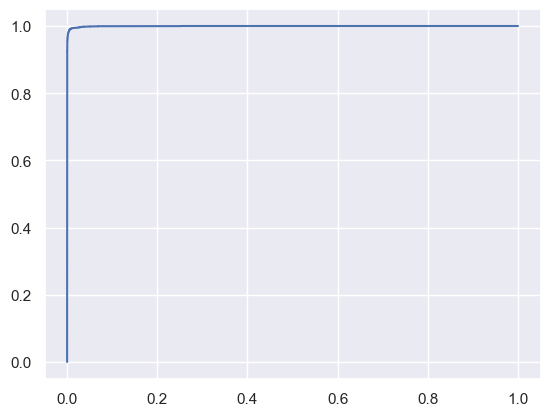

In [ ]:
plt.plot(fpr, tpr)

In [ ]:
import xgboost as xgb

In [ ]:
pipeline_xgb = Pipeline([
    (
        'features', 
        ColumnTransformer([
            (
                'url', 
                TfidfVectorizer(
                    lowercase=True, ngram_range=(4, 4), token_pattern=TOKEN_PATTERN,
                    stop_words = stopword_set, min_df=2, max_df=0.8, analyzer = 'char', smooth_idf = True
                ), 
                'url'
            ),
            (
                'title',
                TfidfVectorizer(
                    lowercase=True, ngram_range=(4, 4), token_pattern=TOKEN_PATTERN,
                    stop_words = stopword_set, min_df=1, max_df=0.8, analyzer = 'char_wb', smooth_idf = True
                ), 
                'title'
            ),
        ])
    ),
    
    # ('scaler', MinMaxScaler()),
    ('xgb', xgb.XGBClassifier(objective = 'binary:logistic', base_score=0.5,
       learning_rate=0.2309, max_depth = 20,
       n_estimators=3,
       seed=0))
])

In [ ]:
pipeline_xgb.fit(learning_content_dataset, Y_train)

In [ ]:
f1_score(Y_test, pipeline_xgb.predict(test_content_dataset))

In [ ]:
f1_score(Y_train, pipeline_xgb.predict(learning_content_dataset))

In [ ]:
test_dataset['label'] = predictions

In [ ]:
test_dataset_submit = test_dataset[['ID', 'label']]

In [ ]:
test_dataset_submit

,ID,label
0,135309,0
1,135310,0
2,135311,0
3,135312,1
4,135313,0
...,...,...
165373,300682,0
165374,300683,0
165375,300684,0
165376,300685,0


In [ ]:
test_dataset_submit.to_csv('submit_attempt.csv')

In [ ]:
data = pd.read_csv('submit_attempt.csv')

In [ ]:
data

,ID,label
0,135309,0
1,135310,0
2,135311,0
3,135312,1
4,135313,0
...,...,...
165373,300682,0
165374,300683,0
165375,300684,0
165376,300685,0


### Margin

In [ ]:
parameters = {
    'site_name__ngram_range': ((1, 1), (2, 2), (3, 3)),
    'site_name__min_df': (3, 5, 7),
    'site_name__max_df': (0.5, 0.75),
    'title__ngram_range': ((1, 1), (2, 2), (3, 3), (4, 4)),
    'title__min_df': (3, 5, 7),
    'title__max_df': (0.5, 0.75),
}

In [ ]:
grid_search = GridSearchCV(pipeline, parameters, cv=3, scoring='f1', verbose=1)

In [ ]:
grid_search.fit(learning_content_dataset, Y_train)

In [ ]:
grid_search.best_params_

{'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}

### Visual Part

In [ ]:
y_val_proba = pipeline.predict_proba(test_content_dataset)[:, 1]

def false_positive(y, y_proba, eps=1e-15):
    if y:
        return (-y) * np.log(y_proba + eps)
    else:
        return 0.0

def false_negative(y, y_proba, eps=1e-15):
    if y:
        return 0.0
    else:
        return (y - 1) * np.log(1 - y_proba + eps)


review_count = 5


positive_error = np.array([false_positive(y, y_proba) for (y, y_proba) in zip(Y_test, y_val_proba)])

negative_error = np.array([false_negative(y, y_proba) for (y, y_proba) in zip(Y_test, y_val_proba)])

max_loss_ids = np.concatenate((
    positive_error.argsort()[::-1][:review_count],
    negative_error.argsort()[::-1][:review_count]
))

In [ ]:
vectorizer = pipeline.steps[0][1]

token2id = {token: i for i, token in enumerate(vectorizer.get_feature_names_out())}

importance = pipeline.steps[1][1].coef_[0]

min_importance = importance.min()
max_importance = importance.max()

In [ ]:
max_loss_ids

array([23496, 13326,  1399, 11297, 35975, 11581, 37143, 30679, 16083,
        8496], dtype=int64)

In [ ]:
y_val_proba

array([2.86937500e-03, 6.95986245e-03, 9.98665301e-01, ...,
       2.10973200e-04, 2.91976185e-02, 1.26228016e-02])

In [ ]:
for i in max_loss_ids:
    review_body = test_content_dataset.reset_index().iloc[i, :].title
    print(review_body)
    
    print(f'predicted class: {pipeline.predict(test_content_dataset)[i]}')
    print(f'true label: {test_content_dataset.reset_index().label.loc[i]}')
    
    review_tokens = re.findall(TOKEN_PATTERN, review_body.lower())
    
    html_string = '''
    <p style="font-size:16px; color:#000000; border: 2px solid #000; text-align: justify; background-color:#ffffff; border-radius: 25px; padding: 20px;">
    '''

    for token in review_tokens:
        if token in token2id:
            weight = importance[token2id[token]]
            if weight < 0:
                component = hex(int(255 - 255 * weight / min_importance))[2:]
                color = f'{component}{component}ff'
            else:
                component = hex(int(255 - 255 * weight / max_importance))[2:]
                color = f'ff{component}{component}'
        else:
            weight = 0.0
            color = 'ffffff'
        html_string += f'<span style="background-color: #{color}"; title="{weight:.2f}">{token}</span> '

    html_string += '</p>'

    display(HTML(html_string))

klinkernyi stupen priamoi euramic classics puma klinker tsentr
predicted class: 0
true label: 1


spartacus hdtv srt subtitles english
predicted class: 0
true label: 1


tatuaggio inchiostro nero stile dotwork carino coppia gufo dino nemec
predicted class: 0
true label: 1


lazizbek jaqulov yoqib qolibsiz uzbekskii klip
predicted class: 0
true label: 1


gulbahorning bahoriy onlari
predicted class: 0
true label: 1


seks
predicted class: 1
true label: 0


seks analnyi
predicted class: 1
true label: 0


hentai hot com
predicted class: 1
true label: 0


seks muzyka intimnyi eroticheskii moment mail
predicted class: 1
true label: 0


antares erotic erotic classic hot trailer official
predicted class: 1
true label: 0


In [ ]:
test_dataset = pd.read_csv('tools//test.csv')
test_dataset.head()

,ID,url,title
0,135309,www.kommersant.ru,Шестой кассационный суд в Самаре начнет работу...
1,135310,urexpert.online,"Что такое индексация алиментов, кем и в каких ..."
2,135311,imperimeha.ru,Женщинам | Империя Меха - Part 12
3,135312,national-porn.com,"Небритые, волосатые киски: Порно всех стран и ..."
4,135313,2gis.ru,67


In [ ]:
test_dataset.head()

,ID,url,title,new_url,url_domain,site_name
0,135309,www.kommersant.ru,Шестой кассационный суд в Самаре начнет работу...,"[www, kommersant, ru]",ru,kommersant
1,135310,urexpert.online,"Что такое индексация алиментов, кем и в каких ...","[urexpert, online]",online,online
2,135311,imperimeha.ru,Женщинам | Империя Меха - Part 12,"[imperimeha, ru]",ru,imperimeha
3,135312,national-porn.com,"Небритые, волосатые киски: Порно всех стран и ...","[national-porn, com]",com,national-porn
4,135313,2gis.ru,67,"[2gis, ru]",ru,2gis
